# Prepare the data

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

### Load data & tokenize

In [2]:
words = open('names.txt', 'r').read().splitlines()
chars = ['.'] + sorted(list(set("".join(words))))
vocab_size = len(chars)

stoi = {char:i for i, char in enumerate(chars)}
itos = {i: char for char, i  in stoi.items()}

print(len(words))
print(vocab_size)

32033
27


### Create a train/val/tast split

In [3]:
block_size = 6

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0]*block_size
        for ch in w+'.':
            ix = stoi[ch]
            Y.append(ix)
            X.append(context)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

# MLP

### Initialize parameters

In [4]:
embed_size = 10
hidden_size = 300

In [5]:
E = torch.randn((vocab_size, embed_size))       # 27 x 10
W1 = torch.randn((embed_size*block_size, hidden_size))  * (5/3) / ((embed_size*block_size)**0.5)
# b1 = torch.randn(hidden_size) * 0.01                          # 300
W2 = torch.randn((hidden_size, vocab_size)) * 0.01           # 300 x 27
b2 = torch.randn(vocab_size) * 0     #  27

bnmean_running = torch.zeros((1, hidden_size))
bnstd_running = torch.ones((1, hidden_size))

bngain = torch.ones((1, hidden_size))
bnbias = torch.zeros((1, hidden_size))
parameters = [E, W1, W2, b2, bnbias, bngain]
for p in parameters:
    p.requires_grad = True

In [6]:
# Number of parameters in the model
params = sum(p.nelement() for p in parameters)
params

26997

# Training

In [7]:
lre = torch.linspace(-3, 0, 1000) 
lrs = 100**lre

In [8]:
lri= []
lossi = []
stepi = []

In [9]:
max_steps = 200000
batch_size = 64
for _ in range(max_steps):
    
    ix = torch.randint(1, Xtr.shape[0], (batch_size, ))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # Forward pass
    emb = E[Xb]
    embcat = emb.view(emb.shape[0], -1)
    
    # Linear layer
    hpreact = embcat @ W1 #+ b1
    
    # -------- Bartch Norm Layer ------------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = (hpreact.std(0, keepdim=True))
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias  
    with torch.no_grad():
        bnmean_running = 0.999*bnmean_running + 0.001*bnmeani
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
    # ---------------------------------------------------------------------------------------------------    
 
    
    # Non-linear layer
    h = torch.tanh(hpreact)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits, Yb)
    
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Update
    lr = 0.1 if _ < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # lri.append(lre[_])
    if _ % 10000 ==0:
        print(f'loss on {_} steps is: {loss.item()}')
    lossi.append(loss.log10().item())

    # break

loss on 0 steps is: 3.3054544925689697


loss on 10000 steps is: 2.1635515689849854
loss on 20000 steps is: 1.8249815702438354
loss on 30000 steps is: 2.0612432956695557
loss on 40000 steps is: 2.0772268772125244
loss on 50000 steps is: 1.9083763360977173
loss on 60000 steps is: 2.2961766719818115
loss on 70000 steps is: 1.8852859735488892
loss on 80000 steps is: 1.7547707557678223
loss on 90000 steps is: 1.9363893270492554
loss on 100000 steps is: 2.0801610946655273
loss on 110000 steps is: 1.557906985282898
loss on 120000 steps is: 2.0072991847991943
loss on 130000 steps is: 1.797333002090454
loss on 140000 steps is: 1.8511070013046265
loss on 150000 steps is: 1.778710126876831
loss on 160000 steps is: 2.044206380844116
loss on 170000 steps is: 1.8364754915237427
loss on 180000 steps is: 2.1850814819335938
loss on 190000 steps is: 1.586240530014038


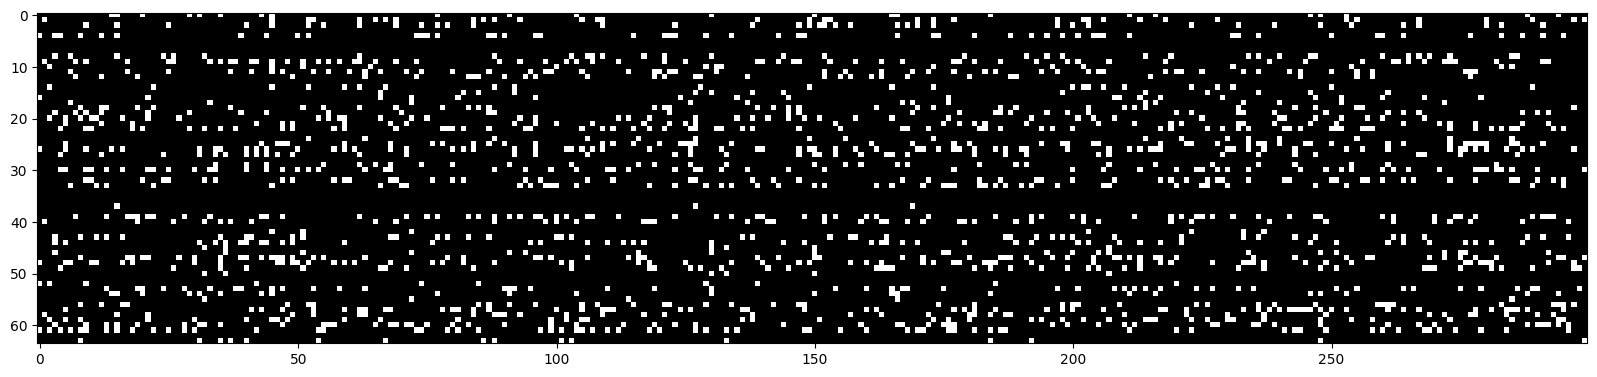

In [10]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > .99, cmap='grey', interpolation='nearest')

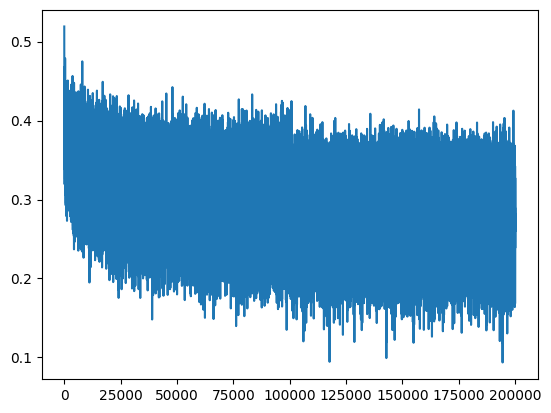

In [11]:
plt.plot(lossi)

In [12]:
with torch.no_grad():
    emb = E[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

### Evaluating loss

In [13]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = E[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 
    hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias  
    h = torch.tanh(hpreact)
    logits = h @ W2 +b2
    loss = F.cross_entropy(logits, y)
    print(split,  loss.item())
    
split_loss('train')
split_loss('val')
    

train 1.8606481552124023
val 2.028737783432007


# Sampling from the model

In [14]:
for i in range(20):
    out = []
    context = [0]*block_size
    while True:
        emb1 = E[torch.tensor([context])]
        embcat = emb1.view(emb1.shape[0], -1)
        hpreact = embcat @ W1 
        hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias  
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        p = F.softmax(logits, dim=1)
        ix = torch.multinomial(p, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix ==0:
            break
        
    print(''.join(itos[i] for i in out ))

aaliah.
aeu.
atuca.
kallin.
kentrictte.
arius.
valli.
fioan.
rehani.
devaiyah.
solianna.
anniel.
linsia.
leryn.
vidhi.
farthm.
amaira.
demarro.
storka.
dezsi.


## Pretty good))